## Recreating some results from Huntingford (2013), _Nature_

Analyis based on the median annual data (`median.nc`) dataset _Ilyas, M., Brierley, C.M. and Guillas, S., 2017. Uncertainty in regional temperatures inferred from sparse global observations: Application to a probabilistic classification of El Niño. Geophysical Research Letters, 44(17), pp.9068-9074._


))) Import required packages and set some global parameters

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# import iris
# import iris.plot as iplt
# import iris.quickplot as qplt




startyr = 1850
endyr = 2018
climateperiod = 11
halfperiod = int(np.floor(climateperiod/2))
numyears_data = endyr - startyr + 1


/home/ucfajsk/.conda/envs/pangeo/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


))) Load the data

<xarray.Dataset>
Dimensions:    (latitude: 36, longitude: 72, time: 169)
Coordinates:
  * latitude   (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) int32 6 18 30 42 54 66 ... 1962 1974 1986 1998 2010 2022
Data variables:
    median     (time, latitude, longitude) float32 ...
Attributes:
    history:  Mon Jul 15 16:11:53 2019: ncks -O -v median ensemble_statistics...
    NCO:      netCDF Operators version 4.7.5 (Homepage = http://nco.sf.net, C...
Coordinates:
  * latitude   (latitude) float64 -87.5 -82.5 -77.5 -72.5 ... 77.5 82.5 87.5
  * longitude  (longitude) float64 -177.5 -172.5 -167.5 ... 167.5 172.5 177.5
  * time       (time) int32 6 18 30 42 54 66 ... 1962 1974 1986 1998 2010 2022
('time', 'latitude', 'longitude')


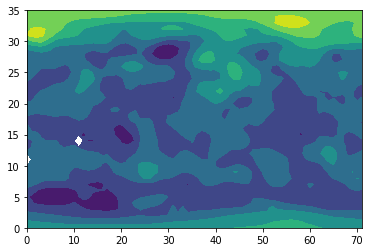

In [61]:
# load the medians of the temperature anomalies from the datafile
dsdir = '/data/aod/Ilyasetal2017_annual/wrt_18501900/'
dsname = 'median.nc'
DS = xr.open_dataset(dsdir + dsname, decode_times=False)
print(DS)
t_anom_ds = DS['median']     # yearly data; [169 x 36 x 72], float32
t_anom = t_anom_ds.values
coords = t_anom_ds.coords
dims = t_anom_ds.dims

print(coords)
print(dims)

t_da = xr.DataArray(t_anom, coords, dims) 

lats = t_anom.shape[1]
lons = t_anom.shape[2]

plt.contourf(t_anom[168])

))) create running 11-yr (-5:+5) pointwise standard deviation.

In [158]:
def detrend(data):
    pwfit = np.polyfit(list(range(climateperiod)), data, 1)
    f = np.poly1d(pwfit)
    
    return data - f(list(range(climateperiod)))
            



rps_running_pointwise_SDs = np.zeros((numyears_data, lats, lons))

for yr in range(numyears_data):
    if yr <= halfperiod or yr >= (numyears_data - halfperiod):
        rps_running_pointwise_SDs[yr, :, :] = np.nan
    else:
        for lat in range(lats):
            for lon in range(lons):
                detrended_t_anom = detrend(t_anom[(yr-halfperiod):(yr+halfperiod+1), lat, lon])
                lsdvar_locationalsdofinterannvar = np.std(detrended_t_anom)
                rps_running_pointwise_SDs[yr, lat, lon] = lsdvar_locationalsdofinterannvar

))) To reproduce fig 1e of Huntingford (2013):: *percentage change in periods before and after 1980*

- for plotting, probably check-out https://rabernat.github.io/research_computing_2018/maps-with-cartopy.html

See the cmap colorschemes at: https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html

Text(0.5, 1.0, 'Difference pre and post in %')

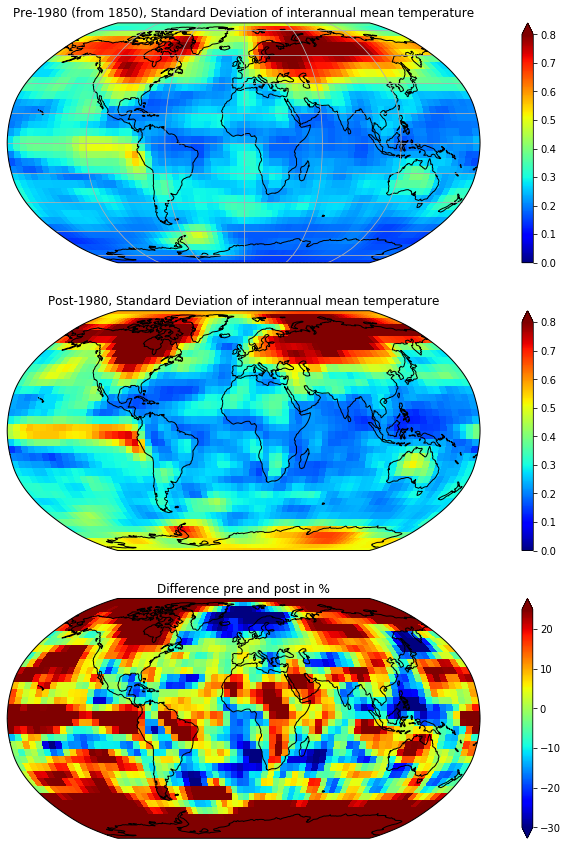

In [156]:
avsdpre_average_sd_before1980 = np.zeros((lats,lons))
avsdpost_average_sd_after1980 = np.zeros((lats,lons))
difsd_difference_sd_beforeandafter1980 = np.zeros((lats,lons))
perc_pointwise_percentagechange_sd_beforeandafter1980 = np.zeros((lats,lons))

for lat in range(lats):
    for lon in range(lons):
        avsdpre_average_sd_before1980[lat,lon] = np.nanmean(rps_running_pointwise_SDs[0:(1980-startyr), lat, lon])
        avsdpost_average_sd_after1980[lat,lon] = np.nanmean(rps_running_pointwise_SDs[(1980-startyr):numyears_data, lat, lon])
difsd_difference_sd_beforeandafter1980 = avsdpost_average_sd_after1980 - avsdpre_average_sd_before1980


perc_pointwise_percentagechange_sd_beforeandafter1980 = (difsd_difference_sd_beforeandafter1980 / avsdpre_average_sd_before1980) * 100




pre1980 = xr.DataArray(avsdpre_average_sd_before1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])
post1980 = xr.DataArray(avsdpost_average_sd_after1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])
perc_da = xr.DataArray(perc_pointwise_percentagechange_sd_beforeandafter1980, coords=[coords['latitude'],coords['longitude']], dims=['latitude','longitude'])





fig = plt.figure(figsize=(15, 15))
colorscheme = 'jet'

pre = fig.add_subplot(3, 1, 1, projection=ccrs.Robinson())
pre.set_global()
pre.coastlines()
pre.gridlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
pre1980.plot(ax=pre, transform=ccrs.PlateCarree(), vmin=0, vmax=.8, cmap=colorscheme)
plt.title('Pre-1980 (from 1850), Standard Deviation of interannual mean temperature')


post = fig.add_subplot(3, 1, 2, projection=ccrs.Robinson())
post.set_global()
post.coastlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
post1980.plot(ax=post, transform=ccrs.PlateCarree(), vmin=0, vmax=.8, cmap=colorscheme)
plt.title('Post-1980, Standard Deviation of interannual mean temperature')


diff = fig.add_subplot(3, 1, 3, projection=ccrs.Robinson())
diff.set_global()
diff.coastlines()
alat = np.linspace(-87.5, 87.5, 36)
alon = np.linspace(-177.5, 177.5, 72)
perc_da.plot(ax=diff, transform=ccrs.PlateCarree(), vmin=-30, vmax=25, cmap=colorscheme)
plt.title('Difference pre and post in %')



In [ ]:
# load pagemask.nc file using xarray
dsdir = 'TemperatureVariability/'
dsname = 'pagemask.nc'
DS = xr.open_dataset(dsdir + dsname)
da = DS.world # select variable
mask = da.values # turn dataset into numpy array
np.place(mask, mask<1, 0)
np.place(mask, mask>=1, 1)
# NB.... mask.shape != grid.shape....

# for lat in mask.shape[0]:
#     for lon in mask.shape[1]:
#         continue


#np.place(mask, mask<1, np.nan)
plt.contourf(mask)

def to_lowres(grid): # grid should be input of 36 x 72 (so for 1 time entry!!)
    lowresgrid = np.zeros((lats, lons))
    iratio = int(grid.shape[0]/lats) # = 10
    jratio = int(grid.shape[1]/lons) # = 10
    
    # on the t_anom grid.
    for i in range(lats): # latitude
        for j in range(lons): # longitude
            lowresgrid[i][j] = np.nanmean(grid[i*iratio:(i*iratio+iratio), j*jratio:(j*jratio+jratio)]) # ratios of scaling

    return lowresgrid        
lowresworldmask = to_lowres(mask)
plt.figure()
plt.contour(lowresworldmask)
print(lowresworldmask)